In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

import datetime
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from tqdm import tqdm

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import os
import gc

#os.chdir("T:\\laupodteam\\AIOS\\Bram\\notebooks\\code_dev\\celldyn_embedder\\sandbox")
os.chdir("/media/UMCU/notebooks/code_dev/celldyn_embedder/sandbox")
sns.set_style("whitegrid")

from celldyn_qc import QcControl

* filter based on group flags
* filter based on suspect flags
* filter based on range
* apply scaling
* correct for diurnal rythm
* impute

In [2]:

read_filters = pd.read_excel("../external/CelldynParams.xlsx", 
            sheet_name="Parameters", skiprows=1)
read_filters.rename(columns={'Unnamed: 0': 'measurement_name', 
            'Unnamed: 1': 'measurement_description'}, inplace=True)
read_filters['measurement_name'] = read_filters.measurement_name.str.split('_')\
                                        .apply(lambda x: "_".join(x[2:]))
filter_dict = read_filters[['measurement_name', 'Intra', 'Inter', 'Min', 'Max']]\
                                        .set_index('measurement_name').to_dict('index')

read_filter_man =  pd.read_excel("../external/reference_values.xlsx")
read_filter_man['measurement_name'] = read_filter_man.Value.str.split('_')\
                                        .apply(lambda x: "_".join(x[2:]))
filter_dict_man = read_filter_man[['measurement_name', 'min', 'max']]\
                                    .set_index('measurement_name').to_dict('index')

for k,v in filter_dict.items():
    try:
        man_min, man_max  = filter_dict_man[k]['min'], filter_dict_man[k]['max']
        if np.isnan(man_min) == False:
            filter_dict[k]['Min'] = man_min
        if np.isnan(man_max) == False:
            filter_dict[k]['Max'] = man_max
    except Exception as  e:
        print(e,k,v)
        pass

''  {'Intra': nan, 'Inter': nan, 'Min': nan, 'Max': nan}


In [3]:
def sigmoid(x):
    #return np.tanh(x)
    return 1/(1+np.exp(-x))

def sigmoid_log(x):
    return sigmoid(np.log(x+1))

In [4]:
#celldyn = pd.read_sas("T:/lab_research/RES-Folder-UPOD/Celldynclustering/E_ResearchData/2_ResearchData/celldyn.sas7bdat")
#celldyn = pd.read_sas("/media/UMCU/data/CellDyn/celldyn.sas7bdat")
celldyn = pd.read_feather("/media/UMCU/data/CellDyn/celldyn.feather")

In [5]:
meta_cols = ['Asp_dt', 'Analyzer', 'studyId_Alle_celldyn', 
             'time_to_measurement', 'gender', 'age' , 'afname_dt',
             'day_of_year', 'week_of_year', 'year', 'first_day',
              'draw_hour', 'meas_hour']
count_columns = [c for c in celldyn.columns if 'c_cnt' in c]
meas_columns = [c for c in celldyn.columns if 'c_b' in c]+['PLT']
mode_columns = [c for c in celldyn.columns if 'c_m' in c]
susp_columns = [c for c in celldyn.columns if 'c_s' in c]
alert_columns = [c for c in celldyn.columns if 'Alrt' in c]
fail_columns = [c for c in celldyn.columns if 'fail' in c]
all_cols  = meta_cols+meas_columns+mode_columns+susp_columns+alert_columns+count_columns+fail_columns
other_cols = [c for c in celldyn.columns if c not in all_cols]

In [6]:
celldyn['gender']= celldyn.gender.str.decode(encoding='latin1')
celldyn['age'] = celldyn.age.astype(int)
celldyn['meas_hour'] = celldyn['Asp_dt'].dt.hour#   apply(lambda x: x.hour)
celldyn['draw_hour'] = celldyn['afname_dt'].dt.hour # .apply(lambda x: x.hour)
celldyn['time_to_measurement'] = (celldyn.Asp_dt-celldyn.afname_dt).dt.total_seconds()
celldyn['time_to_measurement'] = celldyn['time_to_measurement']//3600

In [7]:
def next_weekday(d, weekday):
    days_diff = weekday - d.weekday()
    return (d + datetime.timedelta(days_diff))\
    .replace(hour=0, minute=0, second=0, microsecond=0)

celldyn['day_of_year'] = np.nan
celldyn['day_of_year'] = celldyn.loc[celldyn.c_mode_xLyse==0, 'Asp_dt']\
                            .apply(lambda x: x.dayofyear)
celldyn['week_of_year'] = celldyn.loc[celldyn.c_mode_xLyse==0, 'Asp_dt']\
                            .apply(lambda x: x.weekofyear)

celldyn['year'] = celldyn.loc[celldyn.c_mode_xLyse==0, 'Asp_dt'].apply(lambda x: x.year)
celldyn['first_day'] = celldyn.afname_dt.apply(lambda x: next_weekday(x, 0))

In [51]:
# CD4/CD8 ratio
# T-helper: CD4+
# Cytotoxic: CD8+
# T-inhibitor: CD4+, CD25+, FOXP3
# T-memory

combo_features = [(['mon','mone','blst'],['lym', 'lyme', 'vlym']), 
                  (['bas', 'eos', 'neu'], ['seg', 'bnd', 'mon', 'vlym',
                                           'blst', 'lym', 'lyme', 'nrbc']),
                (['pmon', 'pmone', 'pblst'], ['pvlym','plym','plyme']),
                (['pneu', 'pbas', 'peos'], ['pseg', 'pbnd', 'pmon', 
                                            'pvlym', 'pblst', 'plyme','plym',
                                            'pnrbc'])]
extra_features = 0
derived_columns = []
for t in combo_features:
    for left in t[0]:
        for right in t[1]:
            # add column with the ratios of the columns in the two lists
            celldyn[left+':'+right] = celldyn['c_b_'+left]/celldyn['c_b_'+right]
            derived_columns.append(left+':'+right)
            extra_features += 1
print(f"We added {extra_features} extra features")
meas_columns = meas_columns+derived_columns
meas_names = meas_names + derived_columns

We added 66 extra features


In [49]:
[c for c in meas_names if 'seg' in c]

['seg', 'pseg', 'bas:seg', 'eos:seg', 'neu:seg']

In [9]:
'''
celldyn['mode_combos'] = celldyn[mode_columns]\
                        .apply(lambda x: ",".join([str(_x) for _x in x]),\
                         axis=1)

nan_modes = {}
for c in tqdm(celldyn['mode_combos'].unique()):
    condition = celldyn['mode_combos'] == c
    meas_df=celldyn.loc[condition, meas_columns]
    N = meas_df.shape[0]
    named_c = ",".join([f"{mode_columns[i]}:{str(int(float(v)))}" for i, v in enumerate(c.split(","))])
    nan_list = meas_df.columns[meas_df.isna().sum()==N].tolist()
    if len(nan_list)>0:
        nan_modes[named_c] = nan_list
'''

'\ncelldyn[\'mode_combos\'] = celldyn[mode_columns]                        .apply(lambda x: ",".join([str(_x) for _x in x]),                         axis=1)\n\nnan_modes = {}\nfor c in tqdm(celldyn[\'mode_combos\'].unique()):\n    condition = celldyn[\'mode_combos\'] == c\n    meas_df=celldyn.loc[condition, meas_columns]\n    N = meas_df.shape[0]\n    named_c = ",".join([f"{mode_columns[i]}:{str(int(float(v)))}" for i, v in enumerate(c.split(","))])\n    nan_list = meas_df.columns[meas_df.isna().sum()==N].tolist()\n    if len(nan_list)>0:\n        nan_modes[named_c] = nan_list\n'

There are no special NaN-modes; the NaN's are the result of running in non-reti modus, the affected measurements are:

`
'c_b_retc',
'c_b_pretc',
'c_b_irf',
'c_b_pHPO',
'c_b_pHPR',
'c_b_HDW',
'c_b_MCVr',
'c_b_MCHr',
'c_b_MCHCr',
'c_b_rbcimn',
'c_b_rbcicv',
'c_b_rbcfmn',
'c_b_rbcfcv'
`

In [10]:
cond = (celldyn.time_to_measurement<10) & (celldyn.time_to_measurement>-4)
celldyn = celldyn[cond]

In [11]:
celldyn = celldyn[meas_columns+mode_columns+fail_columns+
                  meta_cols+susp_columns+alert_columns+derived_columns]
meas_names = ["_".join(c.split("_")[2:]) for c in meas_columns]

In [12]:
gc.collect()

0

In [13]:
qc = QcControl(param_file="../external/CelldynParams.xlsx", 
               reference_file="../external/reference_values.xlsx")

''  {'Intra': nan, 'Inter': nan, 'Min': nan, 'Max': nan}


In [14]:
# Quality filters
celldyn = qc.qc_rbc(celldyn.copy())
celldyn = qc.qc_leuko(celldyn.copy())

qc._get_cols(celldyn.copy())
celldyn = qc.suspect_flag_filter(celldyn.copy())
celldyn = qc.fail_filter(celldyn.copy())

  0%|          | 0/21 [00:00<?, ?it/s]

'failmode' failmode


100%|██████████| 21/21 [12:20<00:00, 35.27s/it]


In [15]:
#celldyn = fail_filter(suspect_flag_filter(celldyn.copy()))
#gc.collect()
celldyn_full = celldyn[celldyn[meas_columns+mode_columns+meta_cols].isna().sum(axis=1)==0] # c_mode_cbc & c_mode_rtc are flagged
celldyn_bak = celldyn.copy()

In [16]:
celldyn.reset_index(drop=True).to_feather("/media/UMCU/data/CellDyn/celldyn_checked.feather")
celldyn_full.reset_index(drop=True).to_feather("/media/UMCU/data/CellDyn/celldyn_full.feather")

In [17]:
ssize=1000000
sel = celldyn_full.sample(ssize)
sel['Asp_dt'] = pd.to_datetime(sel['Asp_dt'])

<AxesSubplot:xlabel='draw_hour', ylabel='density'>

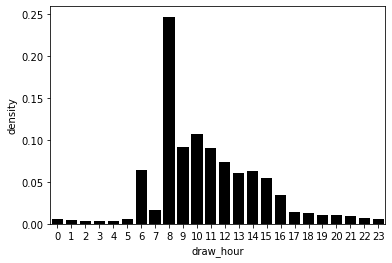

In [18]:
time_col = 'draw_hour'
hour_size = pd.DataFrame(data=sel.groupby(time_col).size(),
                         columns=['counts'])
hour_size.reset_index(inplace=True)
hour_size['density'] = hour_size['counts']/ssize
sns.barplot(data=hour_size, x=time_col, y='density', color='black')

In [19]:
# 'regularise' the data, bound between 1-99th percentile..
for c in tqdm(meas_columns):
    q01 = sel[c].quantile(0.01)
    q99 = sel[c].quantile(0.99)
    sel[c] = sel[c].apply(lambda x: np.min([np.max([q01, x]), q99]))

100%|██████████| 81/81 [16:40<00:00, 12.35s/it]


In [20]:
meas_desc_map = read_filters[['measurement_name' , 'measurement_description']]\
                                        .set_index('measurement_name')\
                                        .to_dict('index')

In [30]:
len(meas_columns)

111

In [37]:
_nrows = 37
k = 0
fig, ax = plt.subplots(ncols=3, nrows=_nrows, figsize=(17, _nrows*7))
for rn in tqdm(range(_nrows)):
    if k<111:
        sns.lineplot(data=sel, x='meas_hour', y=meas_columns[k], ax=ax[rn,0])
        try:
            ptitle = meas_desc_map[meas_names[k]]['measurement_description']
        except Exception as e:
            ptitle = meas_names[k]
        ax[rn,0].set_title(ptitle, fontsize=16)
    if k<110:
        sns.lineplot(data=sel, x='meas_hour', y=meas_columns[k+1], ax=ax[rn,1])
        try:
            ptitle = meas_desc_map[meas_names[k+1]]['measurement_description']
        except Exception as e:
            ptitle = meas_names[k+1]
        ax[rn,1].set_title(ptitle, fontsize=16)
    if k<109:
        sns.lineplot(data=sel, x='meas_hour', y=meas_columns[k+2], ax=ax[rn,2])
        try:
            ptitle = meas_desc_map[meas_names[k+2]]['measurement_description']
        except Exception as e:
            ptitle = meas_names[k+2]
        ax[rn,2].set_title(ptitle, fontsize=16)
    k += 3
plt.ioff()
plt.savefig("../plots/measHour_vs_cb.pdf", dpi=300)
plt.title("hour of measurement vs measurement value")
plt.close()

100%|██████████| 37/37 [20:27<00:00, 33.17s/it]


In [38]:
_nrows = 37
k = 0
fig, ax = plt.subplots(ncols=3, nrows=_nrows, figsize=(17, _nrows*7))
for rn in tqdm(range(_nrows)):
    if k<111:
        sns.lineplot(data=sel, x='draw_hour', y=meas_columns[k], ax=ax[rn,0])
        try:
            ptitle = meas_desc_map[meas_names[k]]['measurement_description']
        except Exception as e:
            ptitle = meas_names[k]
        ax[rn,0].set_title(ptitle, fontsize=16)
    if k<110:
        sns.lineplot(data=sel, x='draw_hour', y=meas_columns[k+1], ax=ax[rn,1])
        try:
            ptitle = meas_desc_map[meas_names[k+1]]['measurement_description']
        except Exception as e:
            ptitle = meas_names[k+1]
        ax[rn,1].set_title(ptitle, fontsize=16)
    if k<109:
        sns.lineplot(data=sel, x='draw_hour', y=meas_columns[k+2], ax=ax[rn,2])
        try:
            ptitle = meas_desc_map[meas_names[k+2]]['measurement_description']
        except Exception as e:
            ptitle = meas_names[k+2]
        ax[rn,2].set_title(ptitle, fontsize=16)
    k += 3
plt.ioff()
plt.savefig("../plots/drawHour_vs_cb.pdf", dpi=300)
plt.title("hour of blood draw vs measurement value")
plt.close()

100%|██████████| 37/37 [21:33<00:00, 34.97s/it]


In [39]:
_nrows = 37
k = 0
fig, ax = plt.subplots(ncols=3, nrows=_nrows, figsize=(17, _nrows*7))
for rn in tqdm(range(_nrows)):
    if k<111:
        sns.lineplot(data=sel, x='time_to_measurement', y=meas_columns[k], ax=ax[rn,0])
        try:
            ptitle = meas_desc_map[meas_names[k]]['measurement_description']
        except Exception as e:
            ptitle = meas_names[k]
        ax[rn,0].set_title(ptitle, fontsize=16)
    if k<110:
        sns.lineplot(data=sel, x='time_to_measurement', y=meas_columns[k+1], ax=ax[rn,1])
        try:
            ptitle = meas_desc_map[meas_names[k+1]]['measurement_description']
        except Exception as e:
            ptitle = meas_names[k+1]
        ax[rn,1].set_title(ptitle, fontsize=16)
    if k<109:
        sns.lineplot(data=sel, x='time_to_measurement', y=meas_columns[k+2], ax=ax[rn,2])
        try:
            ptitle = meas_desc_map[meas_names[k+2]]['measurement_description']
        except Exception as e:
            ptitle = meas_names[k+2]
        ax[rn,2].set_title(ptitle, fontsize=16)
    k += 3
plt.ioff()
plt.savefig("../plots/duration_vs_cb.pdf", dpi=300)
plt.title("sample freshness in hours vs measurement value")
plt.close()

100%|██████████| 37/37 [23:28<00:00, 38.06s/it]


In [40]:
for k, meas_col in tqdm(enumerate(meas_columns)):
    fig, ax = plt.subplots(figsize=(18,7))
    plot_years = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
    ds = sel.loc[(sel.age>1) & (sel.age<=90) 
                    & (sel.year.isin(plot_years)), meas_col]
    ts = sel.loc[(sel.age>1) & (sel.age<=90) 
                    & (sel.year.isin(plot_years)),'first_day']
    ys = sel.loc[(sel.age>1) & (sel.age<=90) 
                    & (sel.year.isin(plot_years)),'year']

    min_year = min(plot_years)
    #ts = ts+(ys-min_year)*52

    plot_df = pd.DataFrame({'t': ts, 'd': ds, 'y': ys})
    plot_df.sort_values('t', inplace=True)

    sns.lineplot(data=plot_df, x='t', y='d', hue='y', ax=ax)

    try:
        ptitle = meas_desc_map[meas_names[k]]['measurement_description']
    except Exception as e:
        ptitle = meas_names[k]

    plt.title(f"{ptitle} over time", fontsize=16)
    plt.ioff()
    plt.savefig("../plots/meas_vs_time_"+meas_col+".pdf", dpi=300)
    plt.close()

111it [39:00, 21.09s/it]


In [41]:
for k, meas_col in tqdm(enumerate(meas_columns)):
    fig, ax = plt.subplots(figsize=(18,7))

    sns.lineplot(data=sel.loc[sel.age<=90], x='age',
                 y=meas_col, hue='gender', ax=ax)

    try:
        ptitle = meas_desc_map[meas_names[k]]['measurement_description']
    except Exception as e:
        ptitle = meas_names[k]

    plt.title(f"{ptitle} versus age", fontsize=16)
    plt.ioff()
    plt.savefig("../plots/meas_vs_age_"+meas_col+".pdf", dpi=300)
    plt.close()

111it [30:20, 16.40s/it]


## With scaling, With manual feature selection, No feature recombinations

In [7]:
sample_df  = celldyn_full.sample(1000000)

In [8]:
num = 7
sample_df.iloc[:, num].max(), sample_df.iloc[:, num].median(), sample_df.iloc[:, num].quantile(0.999), sample_df.columns[num]

(6899290.0, 1.65524, 80.74877630001251, 'c_b_lyme')

In [10]:
# c_b_wvf: consider dropping -> np.maximum(0.90,(np.minimum(1, v)))
# c_b_bnd: consider dropping -> sigmoid_log(v)
# c_b_ig: consider dropping -> sigmoid_log(v)
# c_b_vlym: consider dropping -> sigmoid_log(v)
# c_b_blst: consider dropping -> sigmoid_log(v)
# c_b_nrbc: consider dropping -> sigmoid_log(v)
# c_b_pbnd: consider dropping -> sigmoid_log(v)
# c_b_pig: consider dropping -> sigmoid_log(v)
# c_b_pvlym: consider dropping -> sigmoid_log(v)
# c_b_pnrbc: consider dropping -> sigmoid_log(v)
# c_b_pblst: consider dropping -> sigmoid_log(v)

# c_b_wbc: np.maximum(0.,(np.minimum(40,..
# c_b_neu: np.maximum(0.,(np.minimum(30,..
# c_b_seg: np.minimum(40, celldyn['c_b_seg'])
# c_b_lym: np.minimum(10, celldyn['c_b_lym'])
# c_b_lyme: np.minimum(10, celldyn['c_b_lyme'])

# c_b_mon: np.minimum(5, celldyn['c_b_mon'])
# c_b_mone: np.minimum(5, celldyn['c_b_mone'])
# c_b_eos: np.minimum(5, celldyn['c_b_eos'])
# c_b_bas: np.minimum(0.25, celldyn['c_b_bas'])
# c_b_pmon: np.minimum(40, celldyn['c_b_pmon'])
# c_b_pmone: np.minimum(40, celldyn['c_b_pmone'])
# c_b_peos: np.minimum(15, celldyn['c_b_peos'])
# c_b_pbas: np.minimum(2, celldyn['c_b_pbas'])
# c_b_rdw: np.minimum(30, celldyn['c_b_rdw'])
# c_b_pMIC: np.minimum(13, celldyn['c_b_pMIC'])
# c_b_pMAC: np.minimum(25, celldyn['c_b_pMAC'])
# c_b_mch_Usa: np.minimum(50, celldyn['c_b_mch_Usa'])
# c_b_mchc_usa: np.minimum(50, celldyn['c_b_mchc_usa'])
# c_b_ht: np.minimum(60, celldyn['c_b_ht'])
# c_b_plto: np.minimum(800, celldyn['c_b_plto'])
# c_b_plti: np.minimum(800, celldyn['c_b_plti'])
# c_b_mpv: np.minimum(15, celldyn['c_b_mpv'])
# c_b_pct: np.minimum(0.7, celldyn['c_b_pct'])

# c_b_pdw: np.maximum(12,(np.minimum(20..
# c_b_retc: np.maximum(0,(np.minimum(300..
# c_b_pretc: np.maximum(0,(np.minimum(8..
# c_b_irf: np.maximum(0,(np.minimum(0.8..
# c_b_pHPO: np.maximum(0,(np.minimum(40..
# c_b_pHPR: np.maximum(0,(np.minimum(1..
# c_b_HDW: np.maximum(4,(np.minimum(15..
# c_b_MCVr: np.maximum(60,(np.minimum(140..
# c_b_MCHr: np.maximum(15,(np.minimum(40..
# c_b_MCHCr: np.maximum(22,(np.minimum(36..
# c_b_prP: np.maximum(0,(np.minimum(15..
# c_b_namn: np.maximum(120,(np.minimum(200,..
# c_b_nacv: np.maximum(0,(np.minimum(5,..
# c_b_nimn: np.maximum(100,(np.minimum(170,..
# c_b_nicv: np.maximum(0,(np.minimum(7,..
# c_b_npmn: np.maximum(50,(np.minimum(175,..
# c_b_npcv: np.maximum(0,(np.minimum(16,..
# c_b_ndmn: np.maximum(5,(np.minimum(45,..
# c_b_nfmn: np.maximum(60,(np.minimum(100,..
# c_b_nfcv: np.maximum(v001,(np.minimum(v999,..
# c_b_Lamn: np.maximum(v001,(np.minimum(v999,..
# c_b_Lacv: np.maximum(v001,(np.minimum(v999,...
# c_b_Limn: np.maximum(v001,(np.minimum(v999,...
# c_b_Licv: np.maximum(0,(np.minimum(10,..
# c_b_Pimn: np.maximum(v001,(np.minimum(v999,..
# c_b_Picv: np.maximum(12,(np.minimum(24,..
# c_b_Ppmn: np.maximum(105,(np.minimum(140,..
# c_b_Ppcv: np.maximum(10,(np.minimum(25,..
# c_b_rbcimn: np.maximum(v001,(np.minimum(v999,..
# c_b_rbcicv: np.maximum(v001,(np.minimum(v999,..
# c_b_rbcfmn: np.maximum(v001,(np.minimum(v999,..
# c_b_rbcfcv: np.maximum(5,(np.minimum(23,..
# c_b_rtcfmn: np.maximum(v001,(np.minimum(v999,..
# c_b_rtcfcv: np.maximum(v001,(np.minimum(v999,..
# c_b_hb: np.maximum(v001,(np.minimum(v999,..
# c_b_mch: np.maximum(v001,(np.minimum(v999,..
# c_b_mchc: np.maximum(0.17,(np.minimum(0.25,..

# c_b_pneu: fine as is?
# c_b_pseg: fine as is?
# c_b_plym: fine as is?
# c_b_plyme: fine as is?
# c_b_rbci: fine as is?
# c_b_rbco: fine as is?
# c_b_hgb_usa: fine as is?
# c_b_mcv: fine as is?

droplist = ['c_b_wvf', 'c_b_bnd', 'c_b_ig', 'c_b_vlym', 'c_b_blst', 'c_b_pblst',
            'c_b_nrbc', 'c_b_pbnd', 'c_b_pig', 'c_b_pvlym', 'c_b_pnrbc']
sl_list = ['c_b_bnd', 'c_b_ig', 'c_b_vlym', 'c_b_blst', 'c_b_pblst',
            'c_b_nrbc', 'c_b_pbnd', 'c_b_pig', 'c_b_pvlym', 'c_b_pnrbc']

final_columns = list(set(meas_columns)-set(droplist))

q_scaler = FunctionTransformer(func=lambda x: np.maximum(np.quantile(x,0.001), 
                                              np.minimum(np.quantile(x, 0.999), x)))
sl_scaler = FunctionTransformer(func=sigmoid_log)
wvf_scaler = FunctionTransformer(func=lambda x: np.maximum(0.90,(np.minimum(1, x))))

transformer_list = [('wvf_scaler', wvf_scaler, ['c_b_wvf']),
                    ('q_scaler', q_scaler, final_columns),
                    ('sl_scaler', sl_scaler, sl_list)]

pre_transformer = ColumnTransformer(transformer_list, remainder='passthrough')

In [11]:
del celldyn
gc.collect()

0

In [12]:
reduce_dim = 3
embedder_full = umap.UMAP(n_components=reduce_dim, n_neighbors=51)
le_pipe = Pipeline([('scaler_1', pre_transformer),                    
                    ('scaler_2', StandardScaler()),
                    ('embedder', embedder_full)])

le_pipe.fit(sample_df[meas_columns]) # final_columns

Pipeline(steps=[('scaler_1',
                 ColumnTransformer(transformers=[('wvf_scaler',
                                                  FunctionTransformer(func=<function <lambda> at 0x000000002E9F2040>),
                                                  ['c_b_wvf']),
                                                 ('q_scaler',
                                                  FunctionTransformer(func=<function <lambda> at 0x0000000004E05F70>),
                                                  ['c_b_rbcicv', 'c_b_lyme',
                                                   'c_b_mcv', 'c_b_rdw',
                                                   'c_b_HDW', 'c_b_prP',
                                                   'c_b_pMIC', 'c_b_ndcv',
                                                   'c_b_plto', 'c_b_pdw',
                                                   'c_b_mone', 'c...
                                                   'c_b_MCHr', 'c_b_ht',
                             

In [13]:
color_col = 'c_mode_xLyse'

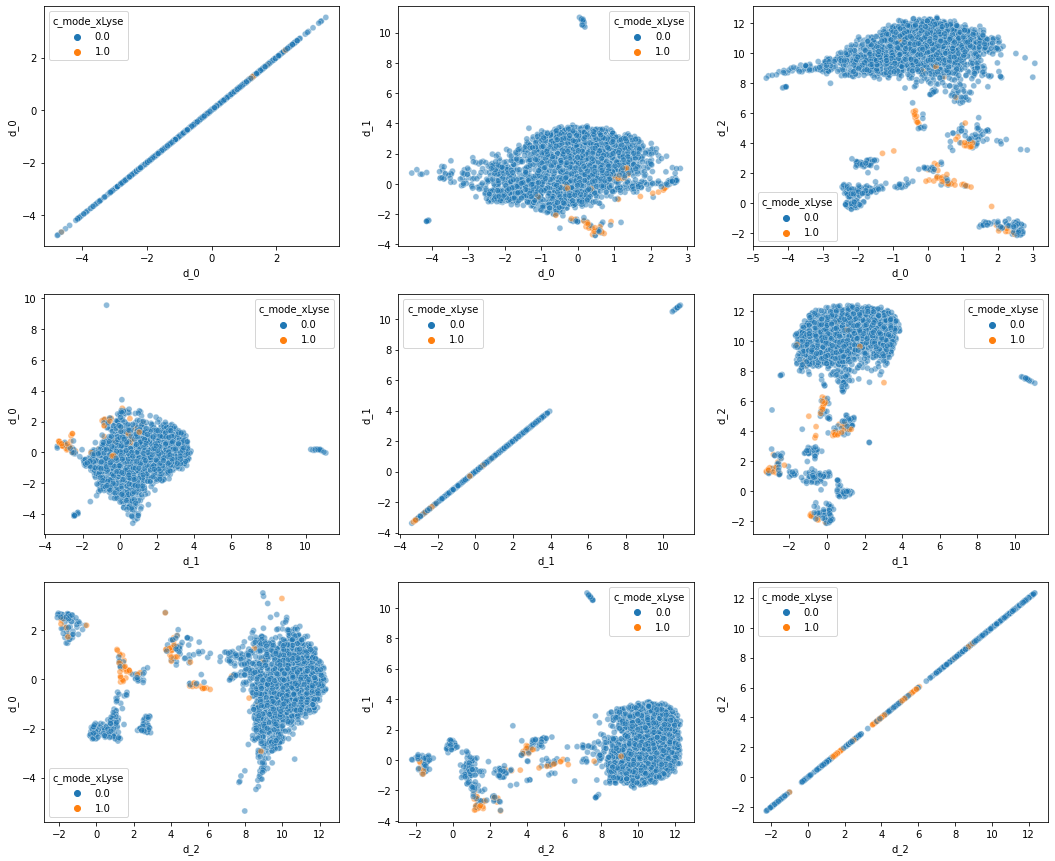

In [14]:
plot_df = pd.DataFrame(data=le_pipe.named_steps['embedder'].embedding_,
                       columns=['d_'+str(i) for i in range(reduce_dim)], 
                       index=sample_df.index)
plot_df = plot_df.join(sample_df[mode_columns+droplist])

reduce_dim = min([6, reduce_dim])
num_rows = int(np.ceil((reduce_dim)**2/3))
fig, ax = plt.subplots(ncols=3, nrows=num_rows, figsize=(18, 5*num_rows))
k = 0
for ki in range(reduce_dim):
    for kj in range(reduce_dim): 
        i = int(k/3)
        j = k%3
        if num_rows > 1:
            sns.scatterplot(data=plot_df.sample(2500), x='d_'+str(ki), y='d_'+str(kj), ax=ax[i,j], 
                            hue=color_col, alpha=0.5)
        else:
            sns.scatterplot(data=plot_df.sample(2500), x='d_'+str(ki), y='d_'+str(kj), ax=ax[k], 
                            hue=color_col, alpha=0.5)
        k += 1

# Imputed

In [15]:
# QuantileTransform -> impute -> inverse transform